In [114]:
import os
import zipfile
from tempfile import TemporaryDirectory
from inference import get_model
from PIL import Image
import roboflow
import pandas as pd
import supervision as sv
from inference import get_model
from PIL.ImageFile import ImageFile

In [159]:
model = get_model("wigglebin/1")

RoboflowAPINotAuthorizedError: Unauthorized access to roboflow API - check API key. Visit https://docs.roboflow.com/api-reference/authentication#retrieve-an-api-key to learn how to retrieve one.

In [119]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def analyze_image(image):
    results = model.infer(image)[0]
    return results

In [152]:
import os
import pandas as pd
from tempfile import TemporaryDirectory

def analyze_downloads():
    downloads_folder = './downloads'
    results = []

    for zip_file in os.listdir(downloads_folder):
        if zip_file.endswith('.zip'):
            zip_path = os.path.join(downloads_folder, zip_file)
            with TemporaryDirectory() as temp_dir:
                extract_zip(zip_path, temp_dir)
                image_files = [f for f in os.listdir(temp_dir) if f.endswith('.jpg') or f.endswith('.png')]
                
                for image_file in image_files:
                    image_path = os.path.join(temp_dir, image_file)
                    image = Image.open(image_path)
                    analysis = analyze_image(image)
                    num_items_detected = len(analysis.predictions)
                    accuracy = sum(pred.confidence for pred in analysis.predictions) / num_items_detected if num_items_detected > 0 else 0
                    results.append((zip_file, image_file, num_items_detected, accuracy))

    # Sort results by number of items detected and accuracy
    results.sort(key=lambda x: (x[2], x[3]), reverse=True)

    # Convert results to a pandas DataFrame
    df = pd.DataFrame(results, columns=['zip_file', 'image_file', 'num_items_detected', 'accuracy'])

    return df

In [153]:
results = analyze_downloads()

In [154]:
# filter out images which where used for training the first model
def filter_initial_training_images(results, training_folder='./data/robo_initial_model_training'):
    # List all images in the initial training folder
    initial_training_images = set(os.listdir(training_folder))
    
    # Filter out these images from the results DataFrame
    filtered_results = results[~results['image_file'].isin(initial_training_images)]
    
    return filtered_results

# Assuming results is your DataFrame
filtered_results = filter_initial_training_images(results)

In [155]:
filtered_results.head()

,zip_file,image_file,num_items_detected,accuracy
0,2024-06-02-19.zip,2024-06-02-19-27.jpg,10,0.708835
2,2024-06-02-19.zip,2024-06-02-19-59.jpg,9,0.780734
3,2024-06-02-19.zip,2024-06-02-19-52.jpg,9,0.777160
4,2024-06-02-19.zip,2024-06-02-19-55.jpg,9,0.769678
5,2024-06-02-23.zip,2024-06-02-23-22.jpg,9,0.769320


In [156]:
filtered_results.to_csv('results_based_on_modal_1.csv', index=False)

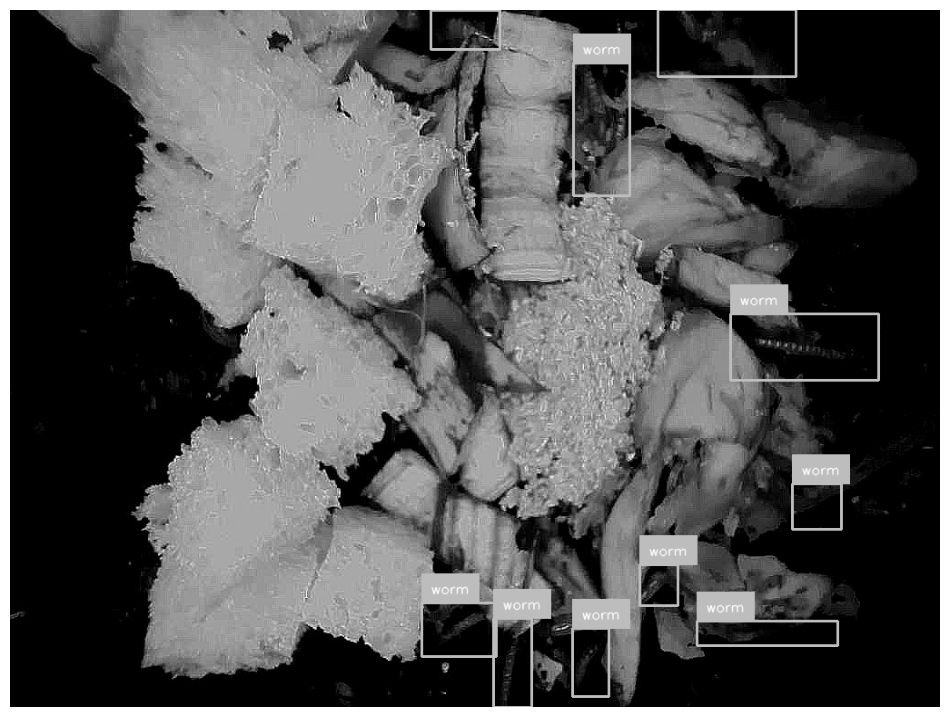

In [157]:
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import os

def show_bounding_boxes(results, downloads_folder='./downloads'):
    # Get the first image file and its corresponding zip file
    first_image_file = results.iloc[0]['image_file']
    zip_file = results.iloc[0]['zip_file']
    
    # Extract the image from the zip file
    zip_path = os.path.join(downloads_folder, zip_file)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(first_image_file) as file:
            image = Image.open(file)
            image.load()  # Ensure the image is fully loaded
    
    # # Analyze the image using the temporary path
    results = analyze_image(image)
    
    # load the results into the supervision Detections api
    detections = sv.Detections.from_inference(results)

    # create supervision annotators
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # annotate the image with our inference results
    annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # display the image
    sv.plot_image(annotated_image)

# Assuming results is your DataFrame
show_bounding_boxes(results)